# Hyperparameter tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
dataset2 = pd.read_csv("hyperparameter.csv")

# Define features and target variable
exclude_columns = ['Date', 'company name']  # Exclude non-numeric columns
features = [col for col in dataset2.columns if col not in exclude_columns and col != 'closing']
target = 'closing'

X = dataset2[features]
y = dataset2[target]

# Replace NaN values with the mean or median
X.fillna(X.mean(), inplace=True)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.028, 0.045),  # Around 0.0359
        'max_depth': trial.suggest_int('max_depth', 14, 16),  # Increase depth slightly
        'n_estimators': trial.suggest_int('n_estimators', 880, 1000),  # Focused range near best
        'reg_alpha': trial.suggest_float('reg_alpha', 0.2, 0.35),  # Around 0.226
        'reg_lambda': trial.suggest_float('reg_lambda', 1.8, 2.2),  # Around 2.00
        'subsample': trial.suggest_float('subsample', 0.68, 0.75),  # Around 0.69
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.96, 1.0),  # Keep high values
        'gamma': trial.suggest_float('gamma', 0.12, 0.18),  # Around 0.14
        'min_child_weight': trial.suggest_int('min_child_weight', 7, 10),  # Focus near 8-9
    }
    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **params)

    # 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2', n_jobs=-1)

    return np.mean(scores)  # Maximize R² score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)  # Adjust n_trials as needed

# Get best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the best model on full training data
best_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_params)
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"Test R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


<ipython-input-3-72c59bed09cf>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
[I 2025-03-14 01:34:02,949] A new study created in memory with name: no-name-082ff09c-0b0e-4f8b-9bb4-599252c44bd2
[I 2025-03-14 01:35:15,681] Trial 0 finished with value: 0.9946782475689527 and parameters: {'learning_rate': 0.03498210910951232, 'max_depth': 15, 'n_estimators': 939, 'reg_alpha': 0.3375697985460824, 'reg_lambda': 2.020958263745449, 'subsample': 0.7067433878104677, 'colsample_bytree': 0.9984203871568958, 'gamma': 0.16545978322541238, 'min_child_weight': 10}. Best is trial 0 with value: 0.9946782475689527.
[I 2025-03-14 01:36:19,899] Trial 1 finished with value: 0.99466169288301 and parameters: {'learning_rate': 0.03734893250601044, 'max_depth': 16, 'n_estimators': 885, 'reg_al

Best Hyperparameters: {'learning_rate': 0.0375706698439368, 'max_depth': 15, 'n_estimators': 1000, 'reg_alpha': 0.303231748170791, 'reg_lambda': 1.8813068428889177, 'subsample': 0.7098904169986414, 'colsample_bytree': 0.9626222444085029, 'gamma': 0.12385525946733267, 'min_child_weight': 7}
Test R² Score: 0.9950
MSE: 3.2976
RMSE: 1.8159


# Finding the optimal days of technical indicators (1 year)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Load dataset
dataset2 = pd.read_csv("dataset2_XG - Copy.csv")

# Define target variable
target = 'closing'

# Define continuous features with lag (avg_price, std_price, avg_volume, ROC)
continuous_lag_features = ['avg_price', 'std_price', 'avg_volume', 'ROC']

# Define updated binary features
binary_features = [
    'Financial updates: Company-specific quarterly, annual, or monthly financial performance reports or statements',
    'Financial: Capital raising activities such as public offerings, loan or lease arrangements, and private placements',
    'Financial:Dividend Declared',
    'Financial: Annual and quater meetings',
    'Technical: Discovery of gold',
    'Operational: Expansion of mining operations (including M & A)',
    'Operational: Opening or clouser of mining',
    'Operational updates: Changes in production output or efficiency',
    'Operational: changes in key management positions',
    'Regulatory:  updates on lawsuits or penalties, Comply with regulatory standards sustainablity and corporate governance',
    'Regulatory: Approval or rejection of mining permits & licenses',
    'Geopolitical events: Political instability or conflicts'
]

# Define additional continuous variable (gold)
additional_continuous_features = ['gold']

# Dictionary to store best results
best_results = {feature: [] for feature in continuous_lag_features}

# Iterate through each lagged continuous feature and find the best day (1 to 30)
for feature in continuous_lag_features:
    for day in range(1, 31):
        feature_name = f"{feature}_{day}"

        # Ensure feature exists in dataset
        if feature_name not in dataset2.columns:
            continue

        # Define input features (selected continuous feature + binary + gold)
        selected_features = [feature_name] + binary_features + additional_continuous_features
        X = dataset2[selected_features].copy()
        y = dataset2[target]

        # Handle missing values
        X = X.fillna(X.mean())  # Avoid inplace modification

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Initialize XGBoost Regressor
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            colsample_bytree=0.12385525946733267,
            gamma=0.14,
            learning_rate=0.0375706698439368,
            max_depth=15,
            min_child_weight=7,
            n_estimators=1000,
            reg_alpha=0.303231748170791,
            reg_lambda=1.8813068428889177,
            subsample=0.7098904169986414,
            random_state=42
        )

        # Perform 10-fold Cross-Validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Evaluate model performance
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # Store results
        best_results[feature].append({
            'day': day,
            'Mean CV R²': np.mean(cv_scores),
            'Test R²': r2,
            'MSE': mse,
            'RMSE': rmse
        })

# Convert results to DataFrames and find the optimal day for each feature
optimal_days = {}
for feature, results in best_results.items():
    results_df = pd.DataFrame(results)
    optimal_day = results_df.loc[results_df['Test R²'].idxmax()]  # Select day with highest R²
    optimal_days[feature] = optimal_day['day']

# Print optimal days for each feature
print("Optimal Days for Each Feature:")
for feature, day in optimal_days.items():
    print(f"{feature}: Day {int(day)}")



Optimal Days for Each Feature:
avg_price: Day 1
std_price: Day 27
avg_volume: Day 26
ROC: Day 30


# Stock price prediction & Evaluating the accuracy



In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Load the dataset
dataset2 = pd.read_csv("1year.csv")

# Define features and target variable
exclude_columns = ['Date', 'company name']  # Exclude non-numeric columns
features = [col for col in dataset2.columns if col not in exclude_columns and col != 'closing']
target = 'closing'

X = dataset2[features]
y = dataset2[target]

# Replace NaN values with the mean or median
X.fillna(X.mean(), inplace=True)
# Drop rows with NaN values in the target variable
dataset2.dropna(subset=[target], inplace=True)  # This line is added

# Redefine X and y after dropping NaN values
X = dataset2[features]  # This line is updated
y = dataset2[target]  # This line is updated

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.12385525946733267,
    gamma=0.14,
    learning_rate=0.0375706698439368,
    max_depth=15,
    min_child_weight=7,
    n_estimators=1000,
    reg_alpha=0.303231748170791,
    reg_lambda=1.8813068428889177,
    subsample=0.7098904169986414,
    random_state=42
)

# Perform 5-fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print cross-validation results and evaluation metrics
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {np.mean(cv_scores):.4f}")
print(f"Test R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

<ipython-input-2-14a837e71a9f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Cross-Validation R² Scores: [0.98389417 0.98501682 0.9807608  0.9835174  0.98447213 0.98392977
 0.98446949 0.98407434 0.98276877 0.98423877]
Mean CV R² Score: 0.9837
Test R² Score: 0.9848
MSE: 0.0154
RMSE: 0.1242


# Plotting the predicted vs actual

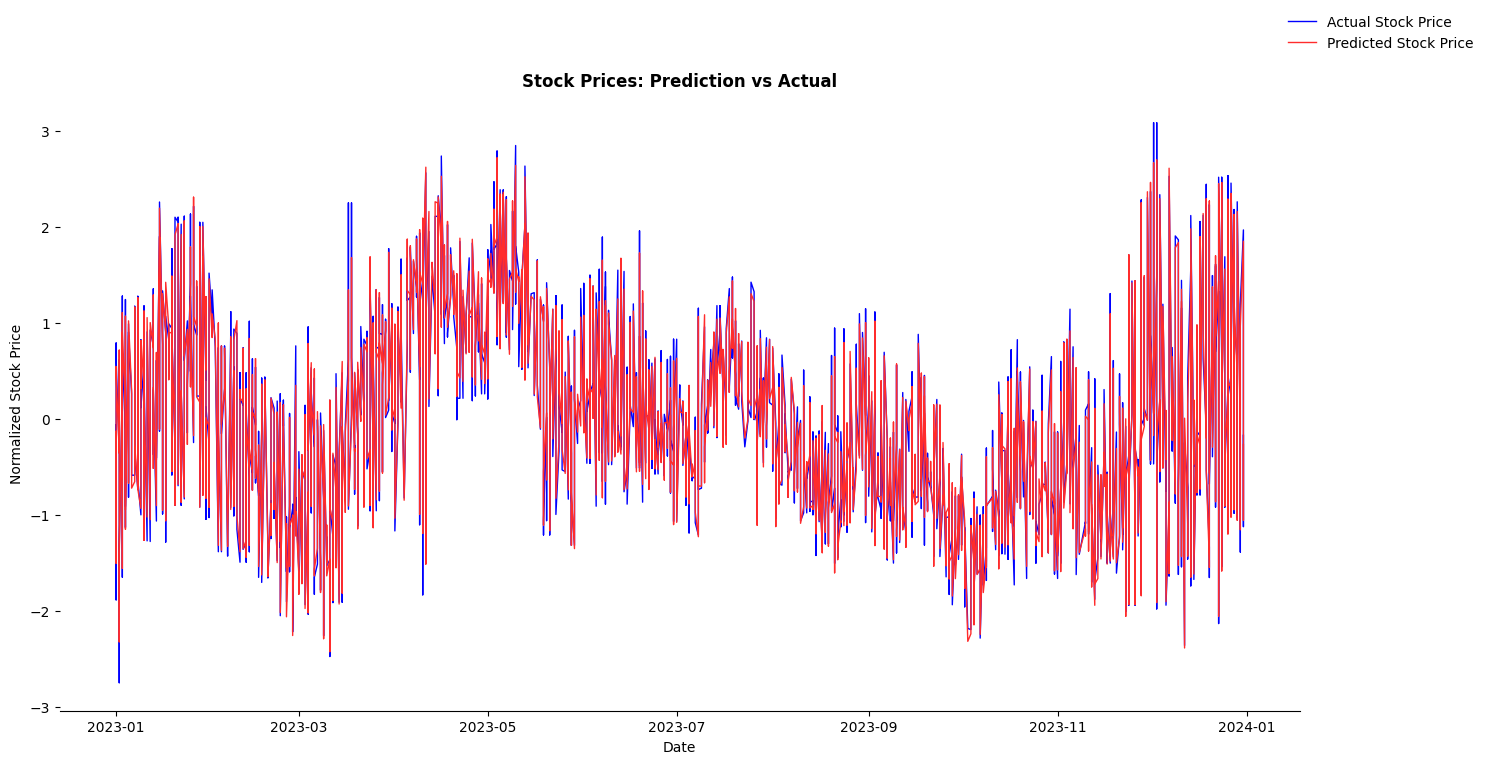

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the standardized dataset
dataset2 = pd.read_csv("1year.csv")

# Ensure 'Date' column is in datetime format
dataset2['Date'] = pd.to_datetime(dataset2['Date'])


# Get test set dates and create a DataFrame for visualization
test_data = dataset2.loc[y_test.index].copy()
test_data['Actual'] = y_test.values
test_data['Predicted'] = y_pred

# Sort by date to maintain chronological order
test_data = test_data.sort_values(by='Date')

# Filter data for the last 1 year
latest_date = test_data['Date'].max()
one_year_ago = latest_date - pd.DateOffset(years=1)
test_data = test_data[test_data['Date'] >= one_year_ago]

# Create a wide figure similar to the reference image
plt.figure(figsize=(16, 8))  # Adjusted for a wide & short look

# Plot actual prices using a dark blue thin line
plt.plot(test_data['Date'], test_data['Actual'], color='#0000ff', linewidth=1, label="Actual Stock Price")

# Plot predicted prices using a red dashed line
plt.plot(test_data['Date'], test_data['Predicted'], color='#FF2C2C', linewidth=1,  label="Predicted Stock Price")

# Format x-axis for a cleaner look
plt.xticks(rotation=0, fontsize=10)  # Keep dates horizontal
plt.yticks(fontsize=10)  # Adjust font size for better readability

# Remove unnecessary borders and grid lines
plt.gca().spines[['top', 'right', 'left']].set_visible(False)
plt.grid(False)

# Adjust legend position to avoid overlapping with the graph
plt.legend(loc='upper right', fontsize=10, frameon=False, bbox_to_anchor=(1.15, 1.15))

# Add chart title
plt.title("Stock Prices: Prediction vs Actual", fontsize=12, fontweight='bold')

# Add x-axis label
plt.xlabel("Date", fontsize=10)

# Add y-axis label
plt.ylabel("Normalized Stock Price", fontsize=10)

# Show plot
plt.show()



# Feature importance

                                              Feature  Importance
3                                         avg_price_1    0.313768
1                                                high    0.238539
0                                                open    0.127657
2                                                 low    0.123445
6                                              ROC_30    0.045952
11              Financial: Annual and quater meetings    0.036880
7                                                gold    0.028456
19  Geopolitical events: Political instability or ...    0.023322
5                                        std_price_27    0.015022
12                       Technical: Discovery of gold    0.013177
4                                       avg_volume_26    0.009352
18  Regulatory: Approval or rejection of mining pe...    0.007281
17  Regulatory:  updates on lawsuits or penalties,...    0.006963
8   Financial updates: Company-specific quarterly,...    0.003570
13  Operat

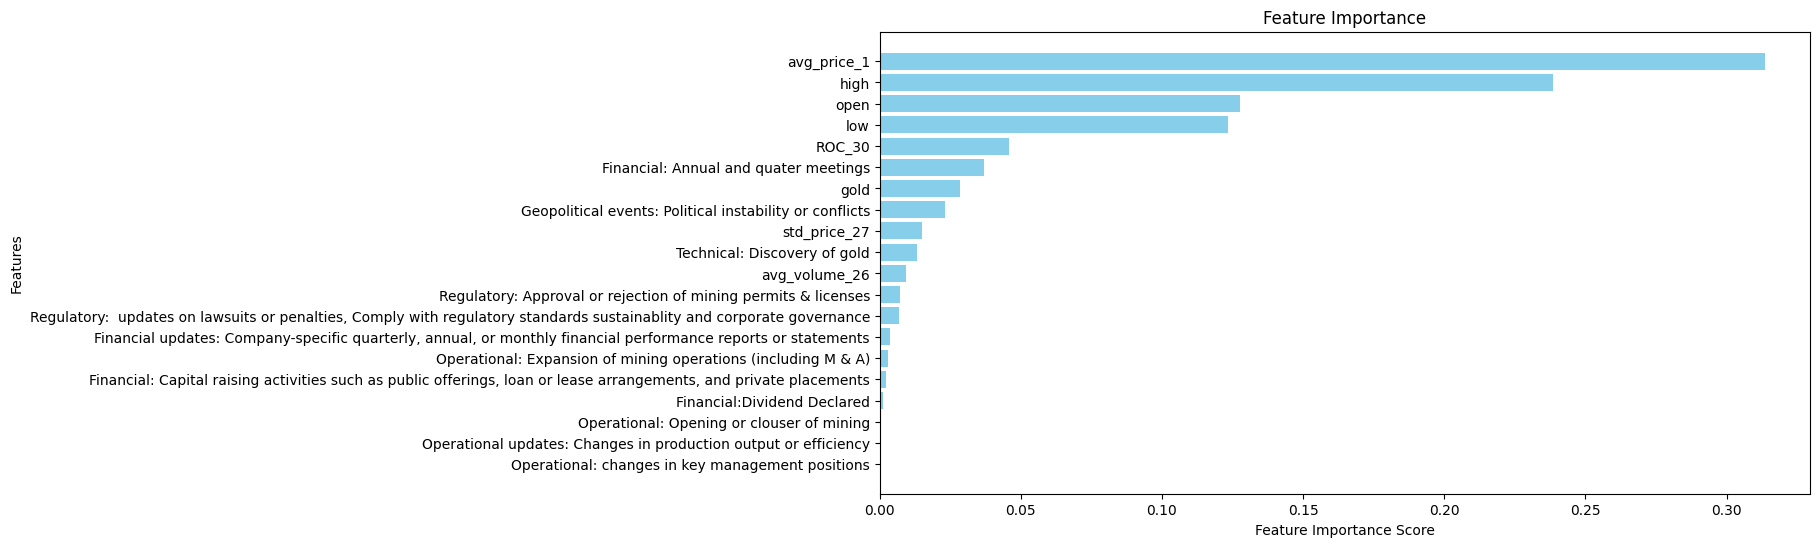

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Sort by importance score
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 15 most important features
top_15_features = importance_df.head(30)

# Print the feature importance scores
print(top_15_features)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

